# Module 2. Homework

In [1]:
import numpy as np
import pandas as pd

## Getting data and explore

In [ ]:
df_orig = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [ ]:
df_orig.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [ ]:
used_columns = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]

In [10]:
df = df_orig[used_columns]
df

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369
...,...,...,...,...,...
9699,140,164.0,2981.107371,2013,15.101802
9700,180,154.0,2439.525729,2004,17.962326
9701,220,138.0,2583.471318,2008,17.186587
9702,230,177.0,2905.527390,2011,15.331551


## EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

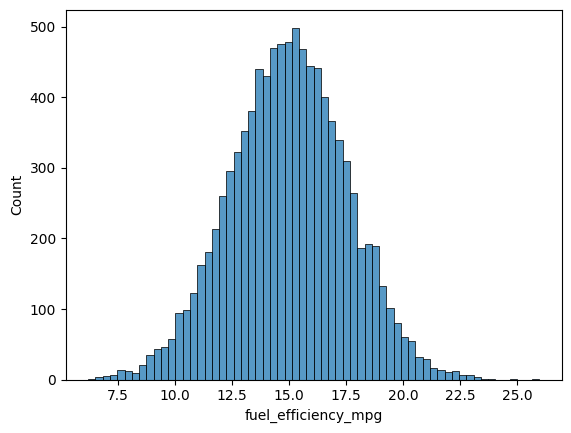

In [15]:
sns.histplot(df.fuel_efficiency_mpg)

## Question 1
There's one column with missing values. What is it?

In [43]:
df_nulls = df.isnull().sum()
df_nulls[df_nulls > 0]

horsepower    708
dtype: int64

## Question 2
What's the median (50% percentile) for variable 'horsepower'?

In [ ]:
df.horsepower.median()

np.float64(149.0)

## Dataset preparation

In [ ]:
np.random.seed(42)

In [ ]:
idx = np.arange(len(df)) # array of indices
np.random.shuffle(idx)

n_val = n_test = int(len(df) * 0.2)
n_train = len(df) - n_val - n_test

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

for d in (df_train, df_val, df_test):
    d.reset_index(drop=True, inplace=True)


## Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

### Linear regression function

In [ ]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

### RMSE

In [177]:
def rmse(y, y_pred):
    return np.sqrt(((y - y_pred) ** 2).mean())

### Feature columns and prediction

In [95]:
base = used_columns[:-1]
ycol = ['fuel_efficiency_mpg']
base, ycol

(['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year'],
 ['fuel_efficiency_mpg'])

### Option 1. Fill with 0

np.float64(0.52)

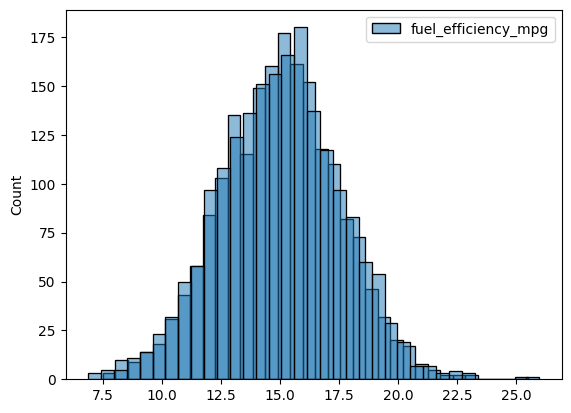

In [169]:
def prepare_X_with_zero(df, cols):
    return df[cols].fillna(0).values

X_train1 = prepare_X_with_zero(df_train, base)

w01, w1 = train_linear_regression(X_train1, df_train[ycol].values)

y_pred1 = w01 + prepare_X_with_zero(df_val, base).dot(w1)

sns.histplot(y_pred1, color='red', alpha=0.5)
sns.histplot(df_val[ycol], color='blue', alpha=0.5)

rmse1 = rmse(df_val[ycol].values, y_pred1)
round(rmse1, 2)

### Option 2. Fill with mean

np.float64(0.46)

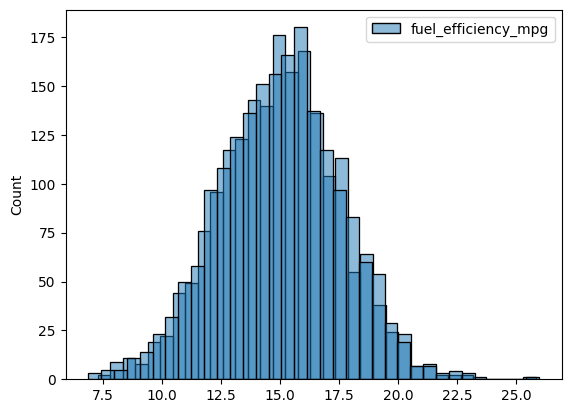

In [170]:
def prepare_X_with_mean(df, cols):
    return df[cols].fillna(df[cols].mean()).values

X_train2 = prepare_X_with_mean(df_train, base)
w20, w2 = train_linear_regression(X_train2, df_train[ycol].values)

y_pred2 = w20 + prepare_X_with_mean(df_val, base).dot(w2)

sns.histplot(y_pred2, color='red', alpha=0.5)
sns.histplot(df_val[ycol], color='blue', alpha=0.5)

rmse2 = rmse(df_val[ycol].values, y_pred2)
round(rmse2, 2)

In [165]:
round(rmse1, 2), round(rmse2, 2)

(np.float64(0.52), np.float64(0.46))

Option 2, filling with mean is better than option 1.

## Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

### Reularized linear regression

In [115]:
def train_linear_regression_regularized(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X) + (r * np.eye(X.shape[1]))
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

### Trying different values of r

In [171]:
results = []

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train_reg = prepare_X_with_zero(df_train, base)
    w0r, wr = train_linear_regression_regularized(X_train_reg, df_train[ycol].values, r)
    y_pred_r = w0r + prepare_X_with_zero(df_val, base).dot(wr)
    rmse_r = rmse(df_val[ycol].values, y_pred_r)
    print(f'r: {r}, RMSE: {rmse_r}')
    results.append((r, rmse_r))

results_df = pd.DataFrame(results, columns=['Regularization', 'RMSE'])

results_df[results_df.RMSE.min() == results_df.RMSE]

r: 0, RMSE: 0.5231162745368177
r: 0.01, RMSE: 0.5232377148572221
r: 0.1, RMSE: 0.525920264927085
r: 1, RMSE: 0.5298076860475559
r: 5, RMSE: 0.530500006322406
r: 10, RMSE: 0.530593962323512
r: 100, RMSE: 0.5306800563552362


,Regularization,RMSE
0,0.0,0.523116


## Question 5
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

In [181]:
seeds = list(range(10))

scores = []

for seed in seeds:
    np.random.seed(seed)
    idx = np.arange(len(df)) # array of indices
    np.random.shuffle(idx)

    n_val = n_test = int(len(df) * 0.2)
    n_train = len(df) - n_val - n_test

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]

    for d in (df_train, df_val, df_test):
        d.reset_index(drop=True, inplace=True)

    X_train = prepare_X_with_zero(df_train, base)
    w0, w = train_linear_regression(X_train, df_train[ycol].values)
    y_pred = w0 + prepare_X_with_zero(df_val, base).dot(w)
    error = rmse(df_val[ycol].values, y_pred)
    scores.append(error)

std = np.std(scores)
round(std, 3)

np.float64(0.007)

## Question 6
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [183]:
np.random.seed(9)

idx = np.arange(len(df)) # array of indices
np.random.shuffle(idx)

n_val = n_test = int(len(df) * 0.2)
n_train = len(df) - n_val - n_test

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

for d in (df_train, df_val, df_test):
    d.reset_index(drop=True, inplace=True)

df_train_val = pd.concat([df_train, df_val])
df_train_val.reset_index(drop=True, inplace=True)

X_train = prepare_X_with_zero(df_train_val, base)
w0, w = train_linear_regression_regularized(X_train, df_train_val[ycol].values, r=0.001)
y_pred = w0 + prepare_X_with_zero(df_test, base).dot(w)
error = rmse(df_test[ycol].values, y_pred)

error

np.float64(0.5156261299214823)